# Debugging

Great error handling helps our users and ourselves when things do go wrong, but only to the point of understanding _what_ went wrong. We still need to fix it: we need to debug our programs.

## First, we need a bug.

Let's build us a quick program to do something useful, like generating the Mandelbrot set.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np

def iterations(c):
    max_iterations = 511
    z = complex(0,0)
    for i in range(1, max_iterations+1):
        z = z**2 + c
        if abs(z) > 2.0:
            return i
    return 1

def mandelbrot(complex_values):
    iters = np.vectorize(iterations)(complex_values)
    return iters

axes = np.arange(-1.5,1.5,0.01)
c = np.array([x+y*1.0j for y in axes for x in axes]).reshape((300,300))
mand = mandelbrot(c)

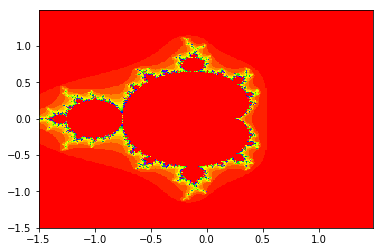

In [2]:
matplotlib.pyplot.pcolormesh(axes, axes, mand, cmap='prism')

It looks _OK_, the structure of the fractal is present, but it's surprising that the inside and the outside of the structure are the same colour. Intuitively, the "background" of the fractal is an area where the iterative function $$z_{i+1} \leftarrow z_{i}^2+c$$ diverges very quickly, so you might expect the "middle" to be a region where it doesn't diverge at all. Why do they look the same?

## `print` debugging

> The most effective debugging tool is still careful thought, coupled with judiciously placed print statements.
>
> Brian W. Kernighan, "UNIX for Beginners"

As researchers, we don't want to indiscriminately start editing our code, hoping that we chance across the change that gives us desired behaviour. We want to take our observations about what's wrong, form a hypothesis as to the cause, investigate that cause, and then make any change suggested by our investigation.

Most debugging tools are primarily used for inspection, letting you look into your code to see the results of its operations. The simplest is the `print()` function, which can show you the path taken through your program and the values of variables at steps along the way.

To investigate our problem with the mandelbrot set, a good place to start would be comparing the results of the computation at a point near the edge of the plot, and a point in the middle.

In [3]:
print(mand[0][0])
print(mand[150][150])

1
1


Hmm, well that's more information: the two regions of the plot look the same because they have the same value. Now to diagnose this further you could start editing the `mandelbrot()` and `iterations()` functions, inserting `print()` calls to inspect the state of the program. But there's a better tool available, so use that.

## Using the debugger

The debugger you'll be working with is [`pdb`](https://docs.python.org/3.4/library/pdb.html), the Python debugger (specifically Jupyter uses a fork called `ipdb`, but it's not wildly different). To use it within a notebook, use the magic `%debug some_python_expression`.

The confusing thing for now is why the Mandelbrot set seems to be diverging quickly at the origin, so that's a good place to point the debugger.

In [ ]:
%debug iterations(complex(0,0))

You'll see a `ipdb>` prompt, at which you can enter a debugger command. You want to **s**tep in to the `iterations()` function so you can see what's going on there, which is achieved with the `s` command.

    ipdb> s
    --Call--
    > <ipython-input-42-ae459efb942b>(5)iterations()
          3 import numpy as np
          4 
    ----> 5 def iterations(c):
          6     max_iterations = 511
          7     z = complex(0,0)

Now, you'll want to investigate what's going on in this function, so use the `n` command a few times to execute the **n**ext line. For brevity let's skip ahead a few goes, you'll need to run `n` more than once to get to this point:

    ipdb> n
    > <ipython-input-42-ae459efb942b>(8)iterations()
          6     max_iterations = 511
          7     z = complex(0,0)
    ----> 8     for i in range(1, max_iterations+1):
          9         z = z**2 + c
         10         if abs(z) > 2.0:

This isn't the first time I've reached this line. You can **p**rint the value of `i` to see where in the loop you are.

    ipdb> p i
    2

It looks like `iterations()` has got past the first iteration of the loop without returning. Which is surprising, because the problem we've seen is that it returns `1` in this case. Well, stepping through the rest of the function may get tedious if it runs through the loop body over five hundred times. Put a breakpoint after the loop to see whether the program gets there. If you're using Python at the command line you can use the **b** pdb command to do this. In Jupyter notebooks, you have to edit your function and insert a call to `pdb.set_trace()` where you want the breakpoint.


In [ ]:
import pdb

def iterations(c):
    max_iterations = 511
    z = complex(0,0)
    for i in range(1, max_iterations+1):
        z = z**2 + c
        if abs(z) > 2.0:
            return i
    pdb.set_trace()
    return 1


Debug this version of the function, and **c**ontinue execution until the breakpoint is reached.

In [ ]:
%debug iterations(complex(0,0))

    ipdb> c
    > <ipython-input-46-6ba6cebdb22b>(11)iterations()
    -> return 1

Python has exited the loop and is about to run the line where it returns 1, which makes our bug clear: the return value when the series doesn't diverge for a value is the same as that when it diverges on the first iteration. Convince yourself that the series _hasn't_ diverged by **p**rinting `z`'s current value, after the loop has exited.

    (Pdb) p z
    0j

That's Python's way of saying it's the complex number 0. We define divergence as $|z| > 2$, which is definitely not the case here. The fix seems to be to return a value _larger_ than the maximum number of iterations, if the loop doesn' terminate early. Here's a fixed version of the function.

In [ ]:
def iterations(c):
    max_iterations = 511
    z = complex(0,0)
    for i in range(1, max_iterations+1):
        z = z**2 + c
        if abs(z) > 2.0:
            return i
    return max_iterations + 1

mand = mandelbrot(c)
matplotlib.pyplot.pcolormesh(axes, axes, mand, cmap='prism')

That looks better (where by "better", I mean "horribly garish"): the regions of the Mandelbrot set are clearly distinguishable.

### My Python is stuck

A top tip on debugging in Jupyter notebooks. If you try running a Python cell and find that it never completes (no results are shown, and `In [*]:` appears in the cell margin), it's possible that you've caused an infinite loop or just a large amount of work to be done. In those cases, you can press Ctrl-C to raise a `KeyboardInterrupt` error.

If you've been using the debugger, though, it's possible that it's still pausing execution in a cell and that's stopping any other Python in the notebook from working. Find the cell that's stuck at the `ipdb>` prompt and issue a **c**ontinue command.